# Simulating the superprocesses
Zhenyao Sun, Math Ph.D. candidate in Peking University, 2018.

## Introduction
This is a Python-Markdown script writen by Zhenyao Sun, Math Ph.D. candidate in Peking University.
The motivation for this script is to give a simulation of Superprocesses, a Stochastic Measure valued process. 
The Method is to use the branching particle system to approximate the superprocesses.
Along the way the simulation of a Brownian path, and Branching Brownian Motions will be given.

## Packages

In [1]:
from scipy.stats import norm
# import the package that generate norm r.v.s
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as sp
# import the package that enable us to draw pictures.

## Classes

### Brownian motions
In this section, let me define the class of Brownian motions. It takes 4 arguements: the initial time, the initial position, the drift coefficient, and the variance after a unite amount of time.
It has 4 hiden arguements: the length of simulation, the length of the steps for simulation, the list of data of times and the list of data of positions.
Since their functions are strongly suggested by their names, there will be no more explanation.
The Brownian motion class has two functions.
- The Realize() function give its a realization. Run this function several times we will get independent several realization of the Brownian motion
- The Plot() function draw the path of the Brownian motion from its data. It will not run Realiza() function.

In [2]:
k = 30
Accuracy = 0.001
def RoundFun(x):
    return int(x/Accuracy + 0.5) * Accuracy

In [3]:
RoundFun(3.7955)

3.7960000000000003

In [4]:
class BrownianMotion:
    InitialTime = 0 
    InitialPosition = 0 
    DriftCoefficient = 0 
    VarianceAtTimeOne = 1
    __NumbersOfSimulation__ = 1000
    __DataOfTime__ = []
    __DataOfPosition__ = []
    
    def __init__(self, InitialTime = 0, InitialPosition = 0, DriftCoefficient = 0, VarianceAtTimeOne = 1):
        self.InitialTime = RoundFun(InitialTime)
        self.InitialPosition = RoundFun(InitialPosition)
        self.DriftCoefficient = DriftCoefficient
        self.VarianceAtTimeOne = VarianceAtTimeOne
        self.__NumbersOfSimulation__ = 1000
        self.__DataOfTime__ = []
        self.__DataOfPosition__ = []
    def Realize(self):
        self.__DataOfTime__ = []
        self.__DataOfPosition__ = []
        __CurrentTime__ = self.InitialTime
        __CurrentPosition__ = self.InitialPosition
        for k in range(self.__NumbersOfSimulation__ + 1):
            self.__DataOfTime__.append( __CurrentTime__ )
            self.__DataOfPosition__.append( __CurrentPosition__ )
            __CurrentTime__ += Accuracy
            __CurrentPosition__ += RoundFun(self.DriftCoefficient * Accuracy +  norm.rvs(scale = numpy.sqrt(self.VarianceAtTimeOne * Accuracy))) 
    def Plot(self):
        #plt.plot(self.__DataOfTime__,self.__DataOfPosition__, linestyle ='-', linewidth = 0.1, marker='o', markersize=0.1, color = "gray")
        plt.plot(self.__DataOfTime__,self.__DataOfPosition__, '-',color = 'yellow', alpha = 0.1, linewidth = 1.8, zorder=5)

    

A typical usage of this class would be like this

### Brownian motion with killing
The next class will be defined is called the Brownian motion with killing. It is a Brownian motion itself, only with a new parameter KilledOrNot to suggests that if it is killed. If it is killed, the __LengthOfSimulation__ should be resigned with the number of its length of lifetime. A new function KilledWithExponentialTimeWithParameter() will be defined whose function is suggestted by its name.
There is a little bug: if a Brownian motion is realized, then the killing function will not erase the data after the killing.

In [5]:
class BrownianMotionWithKilling(BrownianMotion):
    KilledOrNot = 0
    def __init__(self, InitialTime = 0, InitialPosition = 0, DriftCoefficient = 0, VarianceAtTimeOne = 1):
        BrownianMotion.__init__(self, InitialTime, InitialPosition, DriftCoefficient, VarianceAtTimeOne)
        self.KilledOrNot = 0
    def KilledAtTime(self, t):
        NumbersOfSimulationIfKilledAtThisTime = int( max(t - self.InitialTime, 0) / Accuracy )
        if self.KilledOrNot == 1:
            self.__NumbersOfSimulation__ = min(self.__NumbersOfSimulation__, NumbersOfSimulationIfKilledAtThisTime)
        if self.KilledOrNot == 0:
            self.__NumbersOfSimulation__ = NumbersOfSimulationIfKilledAtThisTime
        self.KilledOrNot = 1
    def KilledWithExponentialTimeWithExpectation(self, beta):
        self.KilledAtTime(self.InitialTime + numpy.random.exponential(beta))
    def KilledTime(self):
        return self.__DataOfTime__[-1]
    def KilledPosition(self):
        return self.__DataOfPosition__[-1]
    def GoodOrNot(self):
        return (self.__NumbersOfSimulation__ != 0)
    
    

### Branching Brownian motion Before Time $T$
This class this a bunch of Brownian motion with killing.
It has following parameters: Starting time, Starting Position, Starting Number of Particles, InverseOfKillingRate (i.e. the expectation of the Killing time), MeanOfBranching, CommonDrift, CommonVariation and Trancation Time.
Here we only consider the homogeneous binary branching, so we only have to sipecify the mean of the branch. Notice that the mean taking values in (0,2).

In [6]:
class BranchingBrownianMotion:
    InitialTime = 0
    InitialPosition = 0
    InitialNumberOfParticles = 1
    InverseOfKillingRate = 1
    MeanOfBranching = 1
    CommonDrift = 0
    CommonVariation = 1
    TrancationTime = 10 
    __BrownianMotionInTheSystem__ = []
    def __init__(self, InitialNumberOfParticles = 1, TrancationTime = 10, InverseOfKillingRate = 1, InitialTime = 0, InitialPosition = 0, MeanOfBranching = 1, CommonDrift = 0, CommonVariation = 1):
        self.InitialTime = RoundFun(InitialTime)
        self.InitialPosition = RoundFun(InitialPosition)
        self.InitialNumberOfParticles = InitialNumberOfParticles
        self.InverseOfKillingRate = InverseOfKillingRate
        self.MeanOfBranching = MeanOfBranching
        self.CommonDrift = CommonDrift
        self.CommonVariation = CommonVariation
        self.TrancationTime = RoundFun(TrancationTime)
        self.__BrownianMotionInTheSystem__ = []
        for i in range(self.InitialNumberOfParticles):
            self.AddNewParticleAt(self.InitialTime, self.InitialPosition)
    def AddNewParticleAt(self, Time, Position):
         self.__BrownianMotionInTheSystem__.append( BrownianMotionWithKilling(Time, Position, self.CommonDrift, self.CommonVariation) )
    def RealizeNextParticle(self):
        for particle in self.__BrownianMotionInTheSystem__:
            if particle.KilledOrNot == 0:
                particle.KilledWithExponentialTimeWithExpectation(self.InverseOfKillingRate)
                particle.KilledAtTime(self.TrancationTime)
                particle.Realize()
                if numpy.random.uniform() < (self.MeanOfBranching/2): 
                    self.AddNewParticleAt(particle.KilledTime(), particle.KilledPosition())
                    self.AddNewParticleAt(particle.KilledTime(), particle.KilledPosition())
                return 1
        return 0
    def Realize(self):
        NotDoneYet = 1
        while(NotDoneYet == 1):
            NotDoneYet = self.RealizeNextParticle()
    def Plot(self):
        plt.clf()
        for particle in self.__BrownianMotionInTheSystem__:
            if particle.GoodOrNot():
                particle.Plot()
        plt.savefig("1.pdf")
    def HeatMap(self):
        x = []
        y = []
        for particle in self.__BrownianMotionInTheSystem__:
            if particle.GoodOrNot():
                x.extend(particle.__DataOfTime__)
                y.extend(particle.__DataOfPosition__)
                particle.Plot()
        hist, xedges, yedges = numpy.histogram2d(x, y,bins=100)
        xidx = numpy.clip(numpy.digitize(x, xedges), 0, hist.shape[0]-1)
        yidx = numpy.clip(numpy.digitize(y, yedges), 0, hist.shape[1]-1)
        c = hist[xidx, yidx]
        plt.scatter(x, y, c=c, cmap = "YlGnBu",vmin = 0, vmax = k, s = 0.2, zorder=10)
        plt.savefig('2.pdf')           

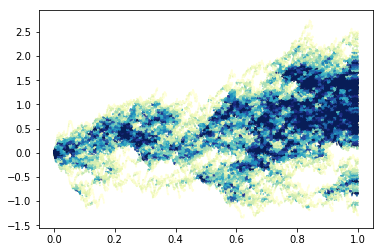

In [7]:
BBM = BranchingBrownianMotion(k, 1, 1/(2*k), 0, 0, 1, 0, 1)
BBM.Realize()
BBM.HeatMap()

In [8]:
range(len([1,2,3]))

range(0, 3)